# Calculating errors when using ENU coordinates (local tangent plane) in a ROS map frame.
### By Roland Arsenault, University of New Hampshire
When using a local tangent plane on an ellipsoid to represent a ROS map frame, errors occure while projecting geographic coordinates on such a plane. Errors increase when distance from the map origin increases.

## How far can we move away from the map origin before errors become significant?

To answer this, we need to decide what significant means. Let's consider a 4 meter uncrewed surface vehicle used for seafloor mapping.

For safety of navigation, we probably want to stay at least 1 meter or more from any obstacles, except for docking and undocking.

The errors we will explore here are for representing absolute geographic coordinates in a map frame, so if use sensors providing relative positions for docking, we won't need to worry about such errors.

The tigher constraint is most likely how close we need to get to a waypoint of a survey line while collecting data.
Let's assume that we consider cross-track errors of 1 meter or less as being acceptable.

How much map error can we have until our complete cross-track error budget is used up by the map error?

It should be noted that positions collected by the mapping system do not go through the ROS tf system and are not affected by this discussion.



## Coding up a solution
Project11 ROS package includes modules for converting lat/lon to and from ECEF as well as calculating geodesic distances.

In [42]:
import math
import project11

Helper function to calculate cartesian distance.

In [43]:
def cartesianDistance(p1,p2):
    distance_squared = 0.0
    for i in range(min(len(p1),len(p2))):
      difference = p2[i]-p1[i]
      distance_squared += difference*difference
    return math.sqrt(distance_squared)

Using an origin at 0 longitude results in a position where the ground plane is aligned with the Y axis. The cosine and sine of the reference latitude are used to move along the ground plane using ECEF's X and Z axis. We'll use a class to keep track of a few pre-calculated values.

In [44]:
class GeoErrorCalculator:
  """Calculate differences between geodesic distances and distances in ECEF in the WGS Ellipsoid surface.

  At geographic position (0,0), the ECEF XYZ axis are aligned with the local ENU's
  up, east and north directions.

  Args:
    latitude: Latitude in degrees where calculations will occur. Defaults to 0
  """
  def __init__(self, latitude=0.0):
    self.latitude = latitude
    self.latitude_radians = math.radians(latitude)
    self.ecef_ref = project11.wgs84.toECEF(self.latitude_radians, 0.0)
    self.sin_lat = math.sin(self.latitude_radians)
    self.cos_lat = math.cos(self.latitude_radians)

  def differencesAtDistanceAzimuth(self, distance, azimuth):
    """Calculate the differences between 
    geodesic and local tangent plane calculation methods.
    Args:
      distance: distance in meters away from the reference point
      azimuth: clockwise direction from north in degrees
    """

    azimuth_radians = math.radians(azimuth)

    ret = {'reference':{'latitude':self.latitude, 'longitude':0.0, 'altitude':0.0}}
    ret['target'] ={'distance':distance, 'azimuth':azimuth}

    # consider the geodesic result the "ground truth"
    geolon, geolat = project11.geodesic.direct(0.0, self.latitude_radians, azimuth_radians, distance)
    ret['geodesic'] = {'latitude':math.degrees(geolat),'longitude':math.degrees(geolon)}

    geodesic_ecef = project11.wgs84.toECEF(geolat, geolon)

    ret['geodesic']['cartesian_distance'] = cartesianDistance(self.ecef_ref, geodesic_ecef)

    north_distance = distance*math.cos(azimuth_radians)
    east_distance = distance*math.sin(azimuth_radians)

    delta_x = -self.sin_lat*north_distance
    delta_y = east_distance
    delta_z = self.cos_lat*north_distance

    tangent_ecef = (self.ecef_ref[0]+delta_x, self.ecef_ref[1]+delta_y, self.ecef_ref[2]+delta_z)

    enu_lat, enu_lon, enu_altitude = project11.wgs84.fromECEFtoLatLong(tangent_ecef[0], tangent_ecef[1], tangent_ecef[2])
    ret['tangent'] = {'latitude':math.degrees(enu_lat), 'longitude':math.degrees(enu_lon), 'altitude':enu_altitude}

    # this is a sanity check to help detect bugs, should be the same as input distance
    ret['tangent']['cartesian_distance'] = cartesianDistance(self.ecef_ref, tangent_ecef)

    ret['tangent']['error'] = {'cartesian_distance': cartesianDistance(geodesic_ecef, tangent_ecef)}

    error_azimuth,error_distance = project11.geodesic.inverse(geolon, geolat, enu_lon, enu_lat)
    ret['tangent']['error']['distance'] = error_distance
    ret['tangent']['error']['azimuth'] = math.degrees(error_azimuth)
    ret['tangent']['error']['altitude'] = enu_altitude
    ret['tangent']['error']['latitude'] = ret['tangent']['latitude'] - ret['geodesic']['latitude']
    ret['tangent']['error']['longitude'] = ret['tangent']['longitude'] - ret['geodesic']['longitude']

    return ret


The above class has method to calculate the errors for one data point. Let's write a function to help us gather data for multiple points along varying parameters of latitude, distance and azimuth and return a plot-friendly structure.

In [45]:
def calculateErrors(latitudes, distances, azimuths):
  ret = {}
  ret['latitudes'] = []
  ret['distances'] = []
  ret['azimuths'] = []

  for latitude in latitudes:
    gec = GeoErrorCalculator(latitude)
    for distance in distances:
      for azimuth in azimuths:
        data = gec.differencesAtDistanceAzimuth(distance,azimuth)
        ret['latitudes'].append(latitude)
        ret['distances'].append(distance)
        ret['azimuths'].append(azimuth)
        if not 'errors' in ret:
          ret['errors'] = {}
          for e in data['tangent']['error']:
            ret['errors'][e] = []
        for e in data['tangent']['error']:
          ret['errors'][e].append(data['tangent']['error'][e])
  return ret
        



Lets test at the equator by going around in a circle at a constant range of 1 km.

In [46]:
data = calculateErrors((0,),(1000,),range(0,360,30))
print(data)

{'latitudes': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'distances': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'azimuths': [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330], 'errors': {'cartesian_distance': [0.07892112444956144, 0.07878904241831558, 0.07852487928768154, 0.07839279725677356, 0.07852487928768154, 0.07878904241831558, 0.07892112444956144, 0.07878904241831557, 0.07852487928768155, 0.07839279725677356, 0.07852487928768154, 0.07878904241831557], 'distance': [8.281575820134286e-06, 8.263679544720388e-06, 8.21795489198083e-06, 8.19384340422223e-06, 8.217954785688826e-06, 8.263679544720388e-06, 8.281575820134286e-06, 8.263679843518285e-06, 8.217954742452084e-06, 8.19384340422223e-06, 8.21795489198083e-06, 8.263679694119337e-06], 'azimuth': [180.0, 209.87828761819117, 239.8757334240895, 270.0, 300.12426770034426, 330.12171238180883, 360.0, 29.878286427955786, 59.875732819172924, 89.99999999999999, 120.12426657591047, 150.12171297692655], 'altitu

Lets try plotting the results

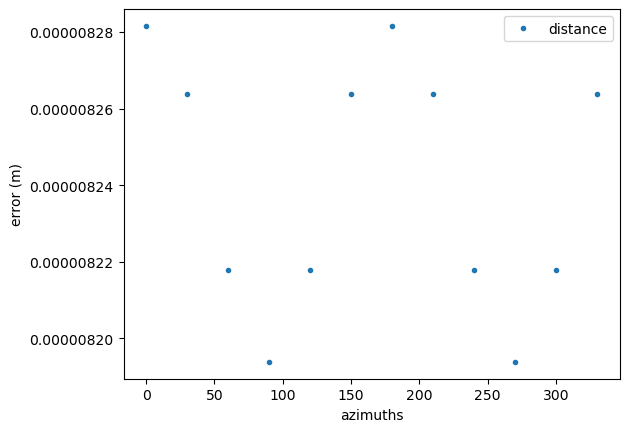

In [47]:
from matplotlib import pyplot as plt

def plotError(data, xaxis='azimuths',yaxis=('distance',)):
  
  for i in range(len(yaxis)):
    plt.subplot(len(yaxis),1,i+1)
    plt.plot(data[xaxis],data['errors'][yaxis[i]],label=yaxis[i],linestyle='None',marker='.')
    plt.ylabel('error (m)')
    plt.legend()
    
  plt.xlabel(xaxis)
  plt.show()

plotError(data)


Make the azimuths denser...

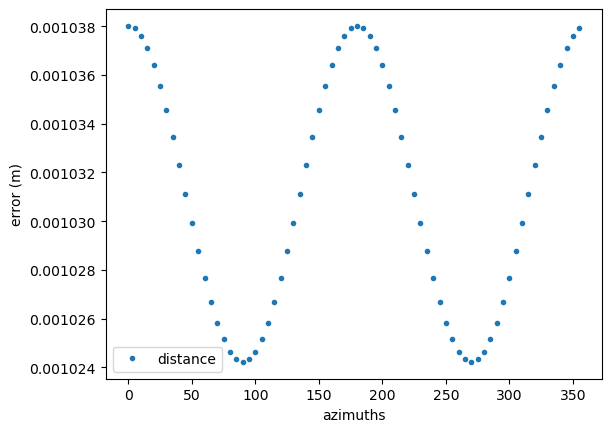

In [48]:
data = calculateErrors((0,),(5000,),range(0,360,5))
plotError(data)

Lets vary the latitude

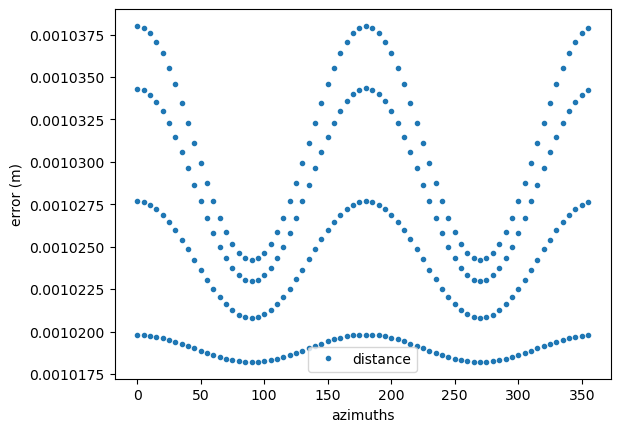

In [49]:
data = calculateErrors((0,25,45,70),(5000,),range(0,360,5))
plotError(data)

Seems like we get larger errors in the north-south directions, so lets stick to north and span the latitudes at a higer resolution

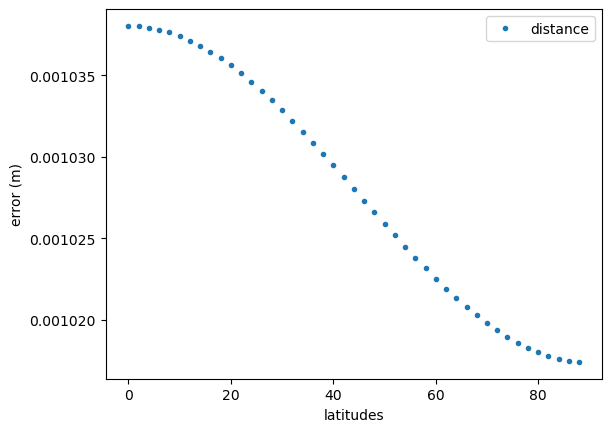

In [50]:
data = calculateErrors(range(0,90,2),(5000,),(0,))
plotError(data,'latitudes')

Lets try combining both

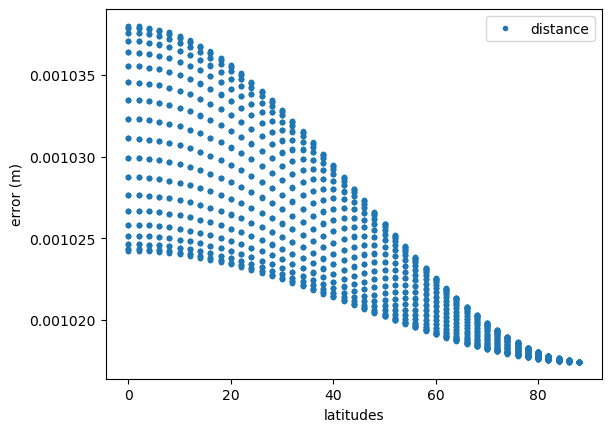

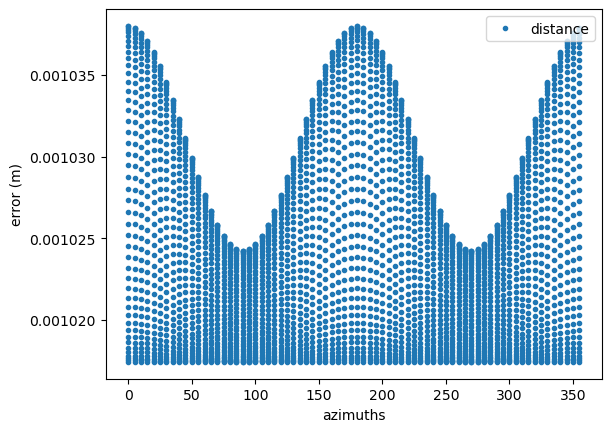

In [51]:
data = calculateErrors(range(0,90,2),(5000,),range(0,360,5))
plotError(data,'latitudes')
plotError(data)

Seems like we get the most errors at the equator, going north-south. Lets now explore distance.

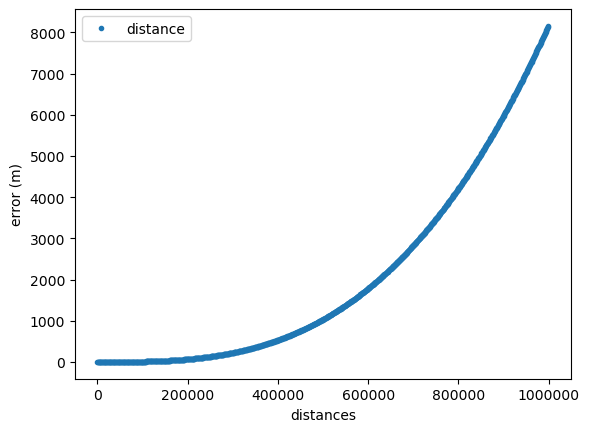

In [52]:
data = calculateErrors((0,),range(0,1000000,1000),(0,))
plotError(data,'distances')


Looks like an 8 kilometer error at a distance of 1000 kilometers. Lets try closer to a typical survey area.

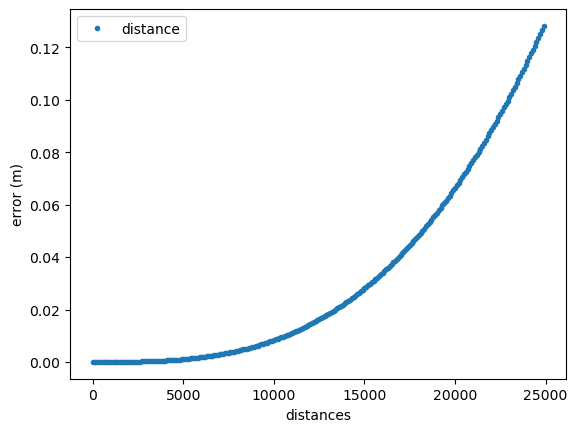

In [53]:
data = calculateErrors((0,),range(0,25000,100),(0,))
plotError(data,'distances')

About an eigth of a meter at a distance of 25 kilometers. Let's find the distance where we'll see a 1 meter error.

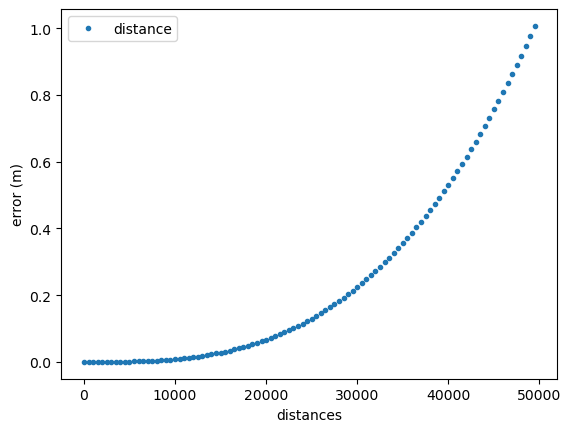

In [54]:
data = calculateErrors((0,),range(0,50000,500),(0,))
plotError(data,'distances')

At about 50 kilometers, we get an error of 1 meter is what should be the worst case senario. Let's verify by varying latitude and azimuth.

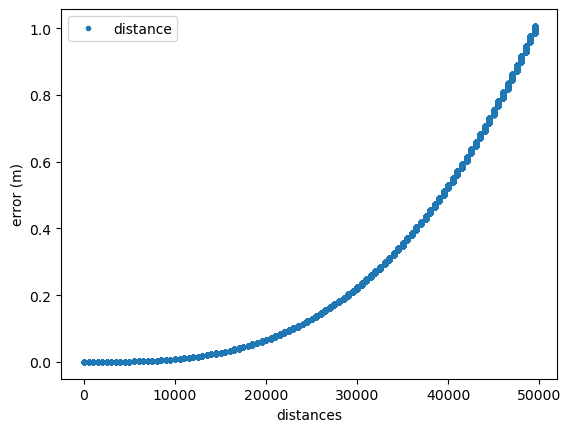

In [55]:
data = calculateErrors(range(0,90,5),range(0,50000,500),range(0,360,10))
plotError(data,'distances')

Errors don't seem to get worse, but we'll focus in at 50km to see if we get the same expected pattern as before.

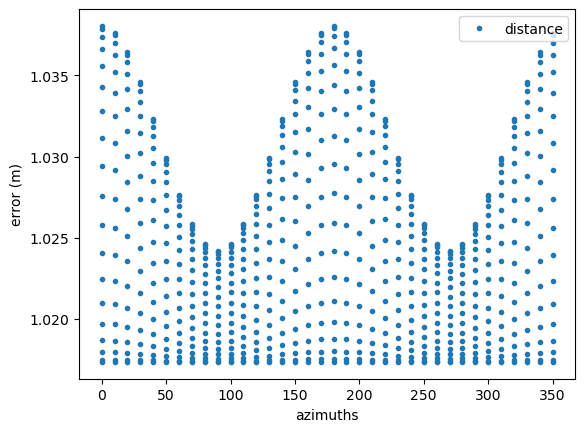

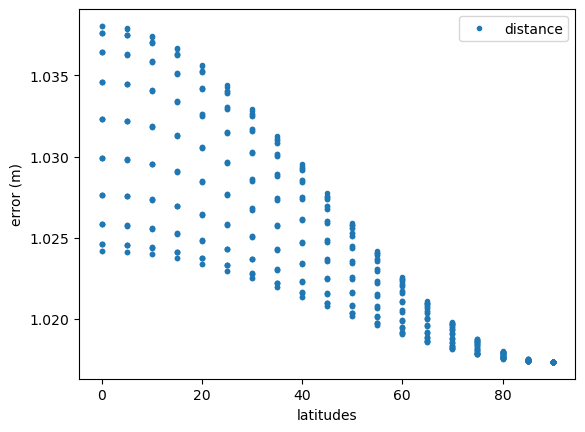

In [56]:
data = calculateErrors(range(0,95,5),(50000,),range(0,360,10))
plotError(data, 'azimuths')
plotError(data, 'latitudes')

This is consistant with north-south direction from the equator having the most errors, but not by much. Let try to plot error ranges between 25 and 50 kilometers.

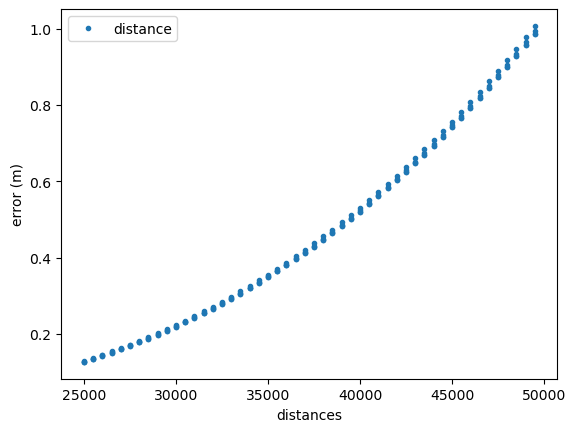

In [58]:
data = calculateErrors((0,90),range(25000,50000,500),(0,90))
plotError(data,'distances')

When converting from geographic coordinates to map_frame, we clamp the results to the surface so the error in altitude does not matter in our case. Let's take a look at the altitude to see why we should be careful if we need to consider height.

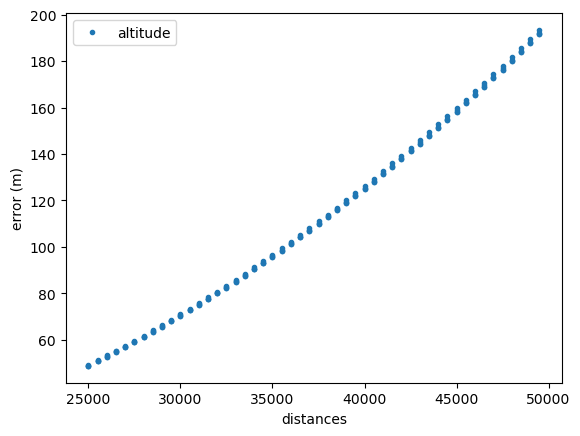

In [60]:
plotError(data,'distances',('altitude',))

## Conclusion

When operating an USV for seafloor mapping we should start considering how to mitigate ROS tf errors when operating more that 30 to 40 kilometers from where out map frame was initialized.